In [ ]:
import numpy as np
import random
from numpy.random import rand
import matplotlib.pyplot as plt
from scipy.sparse import spdiags,linalg,eye
from tqdm import tqdm
import imageio
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Sampler, BatchSampler, Dataset, DataLoader, Subset, SubsetRandomSampler, random_split

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%pip install torchmetrics
from torchmetrics import Accuracy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 868.8/868.8 kB 9.3 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-many

# The Ising Model Setup

Notes:

*   Each spin variable can take a value of $±1$.
*  The Hamiltonian is given by:
 $$
 H = -J\sum_{i,j}s_is_j-𝜇\sum{j}B_js_j
 $$
 With $J$ being the interaction strenght between nearest spins


*   Without an external field, the system exhibits a phase shift when the Curie Temperature ($T_c$) is reached

##Ising 2D

## Setting up the lattice

In [ ]:
np.random.seed(17)

"This function generates a grid of size (N,N) and assigns a random value of -1 or 1 to each element"

def initialize(N: int):
    state = 2*np.random.randint(2, size=(N,N))-1
    return state

N=4
test=initialize(N)
print(test)


[[ 1  1  1 -1]
 [-1  1 -1  1]
 [-1  1 -1  1]
 [-1 -1  1  1]]


In [ ]:
"This function returns the energy of the grid"
def hamiltonian(iArr, N: int):
    energy = 1/2 * sum(-iArr[i][j] * ( iArr[i][(j+1) % N] + iArr[i][(j-1) % N]+ iArr[(i+1) % N][j] + iArr[(i-1) % N][j]) for i in range(N) for j in range (N))
    # the 1/2 is to account for the double counting
    return energy


## Evolving spin configurations

First, we set up a flip function that changes the spin of the $i, j-th$ element of the grid according to a function that depends on the change of energy.

For instance, the state of that element will be changed if

$$
p < e^{(-ΔH β)}
$$

where $β=\frac{1}{k_BT}$ and we consider $k_B = 1$


###¿ How do we understand the probability of changing the state of an element?

The Monte Carlo Algorythm creates lattice configurations that, together, approximate a Boltzman distribution. Here, the probability of a state is proportional to the Boltzman factor; then, the ratio of the probabilities of two states is equal to such factor. With $T=1$ this is

$$
\frac{P(a)}{P(b)} = \frac{e^{-H_a}}{e^{-H_b}} = e^{-(H_a-H_b)}
$$

If we consider a change form state $b$ to state $a$, in this case from $s_i$ to $-s_i$, and the change lowers the energy, it should happen. So, if $ΔH < 0$ the change sould definitely be made, and if $ΔH > 0$ the change sould be made with a probability of $e^{-ΔH}$. This last part means that if a random number between $0$ and $1$ (uniform distribution) is smaller than $e^{-ΔH}$, the spin of the element will switch sign.

Note: the change in energy for one element is:

$$
H_f-H_i = -(-S_i)S_{j} - (-S_iS_{j})=2S_iS_{j}
$$

https://sites.physics.wustl.edu/gradcomputer/wiki/images/6/63/Ising_notes_v2.pdf

In [ ]:
"This function tries to change the value of the i, j-th element of the grid"

def flip(i: int, j: int, iArr, Beta: float):
  M = len(iArr)
  deltaH = 2*iArr[i][j]*(iArr[i][(j+1)%M] + iArr[i][(j-1)%M] + iArr[(i+1)%M][j] + iArr[(i-1)%M][j])
  if deltaH <= 0 or (deltaH > 0)*(np.random.uniform() < np.exp(-deltaH*Beta)):
    iArr[i][j] *= -1
  return iArr

print("Before Flip:\n",test)
flip(2,1,test,1)
print("After Flip:\n",test)
#the 2,1 element should go from -1 to 1

Before Flip:
 [[ 1  1  1 -1]
 [-1  1 -1  1]
 [-1  1 -1  1]
 [-1 -1  1  1]]
After Flip:
 [[ 1  1  1 -1]
 [-1  1 -1  1]
 [-1 -1 -1  1]
 [-1 -1  1  1]]


Magnetization

$$
M = \frac{\sum_{i} S_i}{N^2}
$$

where N is the number of columns (or rows, since the lattice is square)

In [ ]:
"This functions calculates magnetization"
def mag(Arr, N):
  M = np.sum(Arr)
  return M/N**2


"update_rand tries to flip the spin in every position of the array"
def update_rand(Arr,N,beta):
  index = [(row, col) for row in range(N) for col in range(N)]
  samples = random.sample(index, N*N)
  for n in range(len(samples)):
    flip(samples[n][0], samples[n][1], Arr, beta)
  return Arr

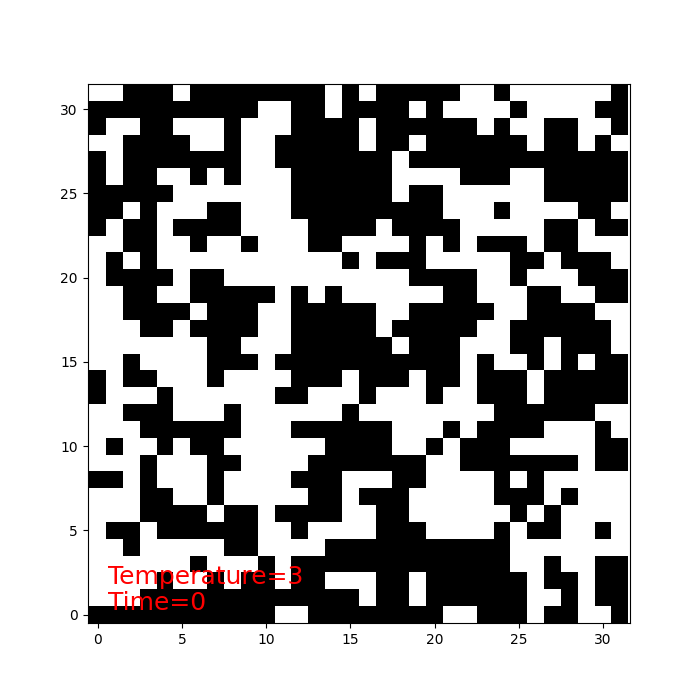

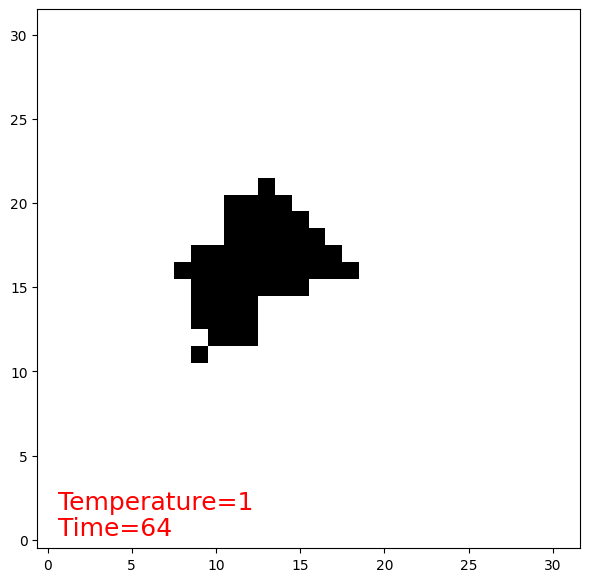

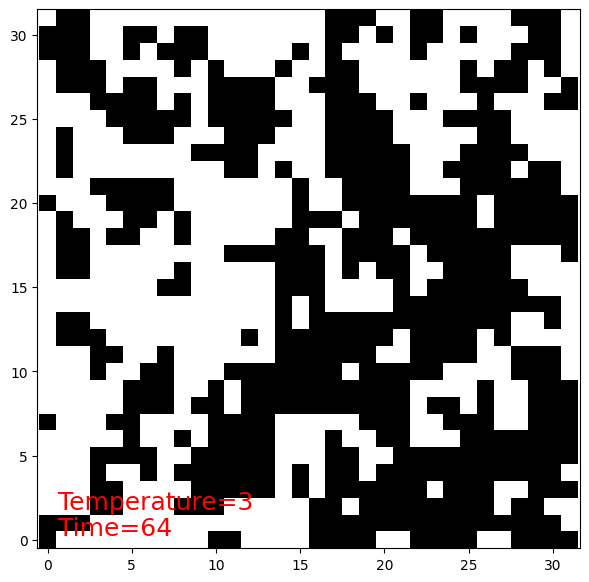

In [ ]:
from IPython.display import Image

def mapPlot(ax,fig, iArr, i, N, images, iT):
    plt.cla()
    X, Y = np.meshgrid(range(N), range(N))
    plt.axis('equal')
    ax.pcolormesh(X, Y, iArr, cmap=plt.cm.bone);
    ax.text(0.6, 0.3,'Time=%d'%i,fontdict={'size': 18, 'color':  'Red'})
    ax.text(0.6, 1.8,'Temperature=%d'%iT,fontdict={'size': 18, 'color':  'Red'})
    fig.canvas.draw()
    image  = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')
    image  = image.reshape(fig.canvas.get_width_height()[::-1] + (3,))
    images.append(image)

def runTemp(iT,iN,images,fig,ax,mcSteps=65):
    pArr = initialize(iN)
    beta=1.0/iT

    for i in range(mcSteps):
        update_rand(pArr, iN, beta)
        mapPlot(ax,fig,pArr,i,iN,images, iT)

images=[]
fig, ax = plt.subplots(figsize=(7,7))
runTemp(1,32,images,fig,ax)
imageio.mimsave('./test.gif', images, fps=5)
Image(open('test.gif','rb').read())

images2=[]
fig, ax = plt.subplots(figsize=(7,7))
runTemp(3,32,images2,fig,ax)
imageio.mimsave('./test2.gif', images2, fps=5)
Image(open('test2.gif','rb').read())

Playing around with the temperatures, we notice that for very low temperatures (close to 0) the system has a net magnetization and all (or almost all) spins have the same value. For larger temperatures (around 2.3), it becomes increasingly'disorganized'.

In [ ]:
k =1

In [ ]:
"This function initialices a grid of size (iN, iN) and calculates the quantities shown above for a given temperature iT     \
as the system evolves a number of steps"

def runTemp(T,N,eqSteps=500,mcSteps=500):
    Arr = initialize(N)                            # initialize
    Ene= []
    Mag = []
    Mag2 = []
    Ene2 = []
    beta=1/(k*T)

    for i in range(eqSteps):                       # equilibrate
        update_rand(Arr, N, beta)

    for i in range(mcSteps):
        update_rand(Arr, N, beta)

        Ene.append(hamiltonian(Arr, N))
        Ene2.append(hamiltonian(Arr, N)**2)
        Mag.append(mag(Arr, N))
        Mag2.append(mag(Arr, N)**2)



    E = sum(Ene)/len(Ene)
    M = sum(Mag)/len(Mag)
    C = (sum(Ene2)/len(Ene2)-E**2)/T**2
    X = (sum(Mag2)/len(Mag2)-M**2)/T
    return E,M,C,X

In [ ]:
N = 10
nt = 100
T  = np.linspace(0.5,4,nt)
E,M,C,X = np.zeros(nt), np.zeros(nt),np.zeros(nt), np.zeros(nt)
for temp in tqdm (range (nt), desc="Loading..."):
    E[temp],M[temp],C[temp],X[temp] = runTemp(T[temp],N,eqSteps=2000,mcSteps=2000)

Loading...: 100%|██████████| 100/100 [07:07<00:00,  4.28s/it]


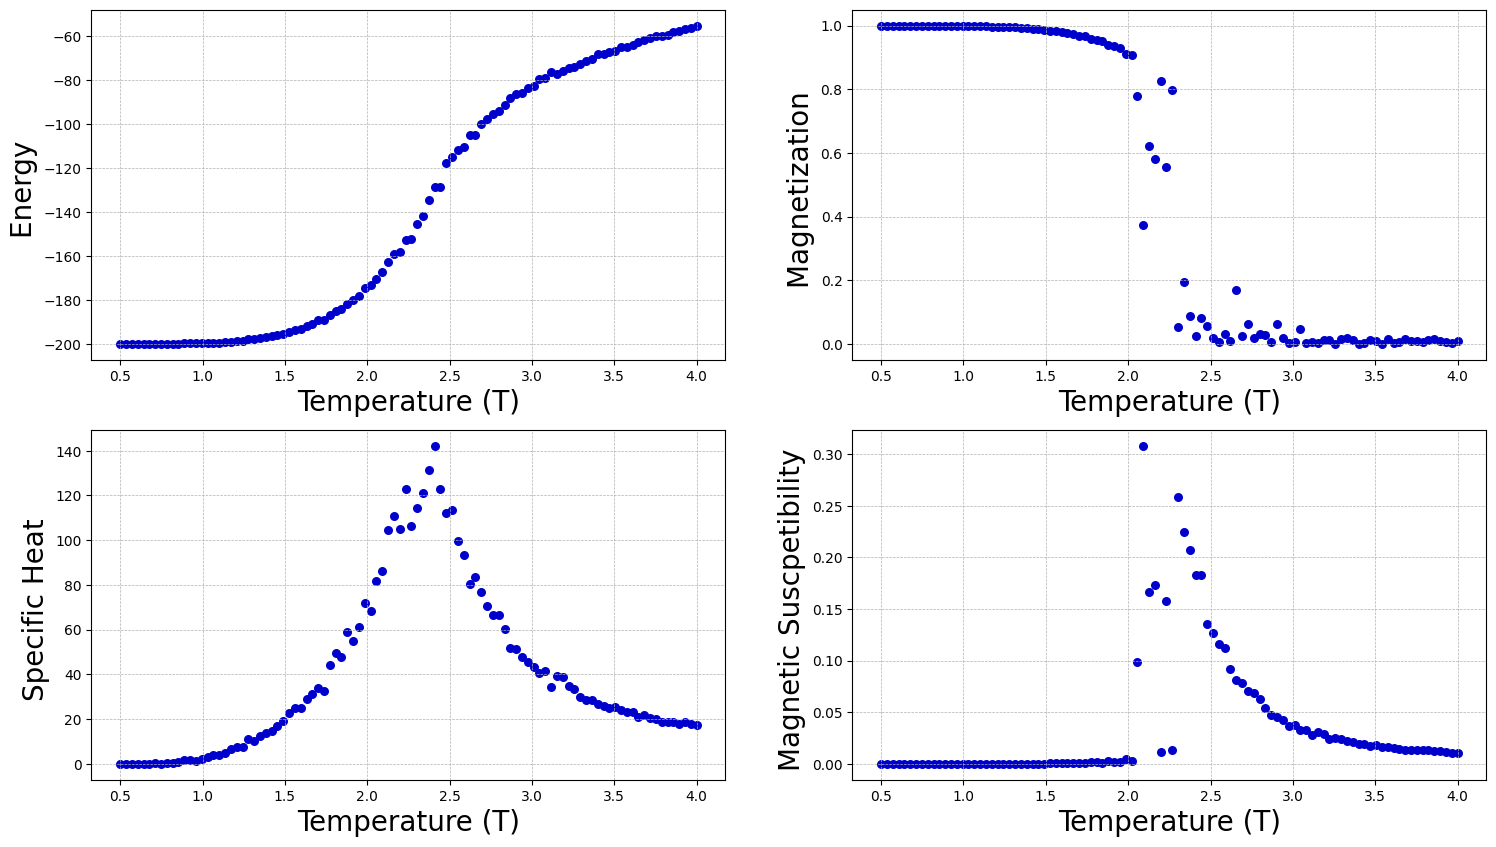

In [ ]:
f = plt.figure(figsize=(18, 10));

sp =  f.add_subplot(2, 2, 1 );
plt.scatter(T, E, s=30, marker='o', color='mediumblue')
plt.xlabel("Temperature (T)", fontsize=20);
plt.ylabel("Energy ", fontsize=20);         plt.axis('tight');
plt.grid(True, which='both', linestyle='--', linewidth=0.5)


sp =  f.add_subplot(2, 2, 2 );
plt.scatter(T, np.abs(M), s=30, marker='o', color='mediumblue')
plt.xlabel("Temperature (T)", fontsize=20);
plt.ylabel("Magnetization ", fontsize=20);         plt.axis('tight');
plt.grid(True, which='both', linestyle='--', linewidth=0.5)


sp =  f.add_subplot(2, 2, 3 );
plt.scatter(T, C, s=30, marker='o', color='mediumblue')
plt.xlabel("Temperature (T)", fontsize=20);
plt.ylabel("Specific Heat ", fontsize=20);         plt.axis('tight');
plt.grid(True, which='both', linestyle='--', linewidth=0.5)


sp =  f.add_subplot(2, 2, 4 );
plt.scatter(T, X, s=30, marker='o', color='mediumblue')
plt.xlabel("Temperature (T)", fontsize=20);
plt.ylabel("Magnetic Suscpetibility ", fontsize=20);         plt.axis('tight');
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

In [ ]:
Tc = 2/np.log(1 + np.sqrt(2))
print('Analytic critical temperature: ', Tc)

Analytic critical temperature:  2.269185314213022


# Constructing Ising Model Simulation

We create a class to evolve a configuration at a given temperature T and save the evolved state to a dataset

In [ ]:
import h5py
class Ising():

    def __init__(self, iN, Temp):
        self.N   = iN
        self.T   = Temp
        self.arr = self.initialize()
        self.steps = 2000

        self.E   = np.array([])
        self.M   = np.array([])
        self.E2   = np.array([])
        self.M2   = np.array([])
        self.nsim = 100

    "creates the lattice"
    def initialize(self):
        state = 2*np.random.randint(2, size=(self.N,self.N))-1
        return state

    "updates the state 2000 times and saves the energy and magnetization for each step"
    def simulate(self, a):
        beta = 1./self.T
        for i in range(self.steps):
            update_rand(a, self.N, beta)
            Ene = hamiltonian(a, self.N)
            Mag = mag(a, self.N)
            self.E   = np.append(self.E,Ene)  # arrays with 2000 positions
            self.M   = np.append(self.M,Mag)
            self.E2 = np.append(self.E2, Ene**2)
            self.M2 = np.append(self.M2, Mag**2)


    "Calculates mean values over the arrays"
    def lastAvg(self):
        avgE = np.mean(self.E)
        avgM = np.mean(self.M)
        avgC = (np.mean(self.E2)-avgE**2)/self.T**2
        avgX = (np.mean(self.M2)-avgM**2)/self.T
        return avgE,avgM,avgC,avgX


    "This method creates 'nsim' grids and evolves them. Then, saves the final state of the grid and the magnetization of each system,"

    def simulate_save(self,pre=''):
        h5f  = h5py.File((pre)+'data_'+str(self.T)+'.h5', 'a')     #this allows to or create or append (if it already exists) to a file
        data = np.array([])   #np.empty((1,self.N,self.N), int)
        mags = np.array([])
        beta  = 1./self.T
        a = self.arr

        for n in range(self.nsim):
            if n % 25 == 0:
                print("sim",n)

            for n in range(1000):
              update_rand(a ,self.N,beta)
            self.simulate(a)

            #for each simulation we want to save the magnetization and the array
            E, M, C, X = self.lastAvg()
            pMag = M
            data = np.append(a,data)
            mags  = np.append(pMag,mags)

        #now we write the output array into a dataset
        data = np.reshape(data,(self.nsim,self.N,self.N))
        h5f.create_dataset('data', data=data)    # This creates a dataset in the file with the evolved arrays
        h5f.create_dataset('mag' , data=mags)    # This creates a datset in the file with the magnetization of the evolved arrays
        h5f.close()



    def plotEvol(self):
        ts = range(len(self.E))
        f = plt.figure(figsize=(18, 10)); #
        plt.tight_layout()

        sp =  f.add_subplot(2, 2, 1 );
        plt.scatter(ts, self.E, s=50, marker='o', color='IndianRed')
        plt.xlabel("step", fontsize=20);
        plt.ylabel("Energy ", fontsize=20);         plt.axis('tight');

        sp =  f.add_subplot(2, 2, 2 );
        plt.scatter(ts, self.M, s=50, marker='o', color='IndianRed')
        plt.xlabel("step", fontsize=20);
        plt.ylabel("Magnetization ", fontsize=20);         plt.axis('tight');


## Constructing simulation

We create an object of the class Ising with atributes T (a value from a list of temperatures) and N=10 (Meaning our grid will be 10 x 10). We then create a file for each of the temperatures and call the simulate_save method to run the Ising Model and create datasets of evolved arrays and their magnetization for each temperature in T

In [ ]:
import os
nt=10
T = np.round(np.linspace(0.5, 4, nt),2)
print(T)
for temp in tqdm (range (nt), desc="Loading..."):
    filename='data_'+str(T[temp])+'.h5'
    try:
        os.remove(filename)
    except OSError:
        pass
    test = Ising(10,T[temp])
    test.simulate_save()

f = h5py.File('data_1.67.h5', 'r')
list(f.keys())
f['data'].shape
!ls

[0.5  0.89 1.28 1.67 2.06 2.44 2.83 3.22 3.61 4.  ]


Loading...:   0%|          | 0/10 [00:00<?, ?it/s]

sim 0
sim 25
sim 50
sim 75


Loading...:  10%|█         | 1/10 [07:00<1:03:01, 420.14s/it]

sim 0
sim 25
sim 50
sim 75


Loading...:  20%|██        | 2/10 [13:52<55:24, 415.59s/it]  

sim 0
sim 25
sim 50
sim 75


Loading...:  30%|███       | 3/10 [21:05<49:23, 423.30s/it]

sim 0
sim 25
sim 50
sim 75


Loading...:  40%|████      | 4/10 [28:30<43:13, 432.20s/it]

sim 0
sim 25
sim 50
sim 75


Loading...:  50%|█████     | 5/10 [35:28<35:34, 426.85s/it]

sim 0
sim 25
sim 50
sim 75


Loading...:  60%|██████    | 6/10 [42:05<27:47, 416.76s/it]

sim 0
sim 25
sim 50
sim 75


Loading...:  70%|███████   | 7/10 [48:14<20:03, 401.14s/it]

sim 0
sim 25
sim 50
sim 75


Loading...:  80%|████████  | 8/10 [54:11<12:54, 387.07s/it]

sim 0
sim 25
sim 50
sim 75


Loading...:  90%|█████████ | 9/10 [1:00:01<06:15, 375.64s/it]

sim 0
sim 25
sim 50
sim 75


Loading...: 100%|██████████| 10/10 [1:05:37<00:00, 393.73s/it]

data_0.5.h5   data_1.28.h5  data_2.06.h5  data_2.83.h5	data_3.61.h5  drive
data_0.89.h5  data_1.67.h5  data_2.44.h5  data_3.22.h5	data_4.0.h5   sample_data


In [ ]:
class DataSet(Dataset):
    def __init__(self, samples, labels, temps):
        super(DataSet, self).__init__()
        self.labels  = labels
        self.samples = samples
        self.temps   = temps
        if len(samples) != len(labels):
            raise ValueError(
                f"should have the same number of samples({len(samples)}) as there are labels({len(labels)})")

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, index):
        y = self.labels[index]
        x = self.samples[index]
        t = self.temps[index]
        return x, y, t

#read all the different files and make a dataset
all_data  = None
all_temps = None
for temp in tqdm (range (nt), desc="Loading..."):
    f = h5py.File('data_'+str(T[temp])+'.h5', 'r')
    if temp == 0:
        all_data  = f['data']
        all_temps = np.ones(all_data.shape[0])*T[temp]
    else:
        all_data  = np.append(all_data, f['data'],axis=0)
        all_temps = np.append(all_temps,np.ones(f['data'].shape[0])*T[temp])

all_data    = np.reshape(all_data,(all_data.shape[0],all_data.shape[1]*all_data.shape[2]))
T_transition = Tc
# each elemento of the dataset all_data is assigned a label according to the temperature (1 if it´s less than the critical temperature and cero otherwise)
all_labels  = np.where(all_temps <= T_transition, 1, 0)
all_dataset = DataSet(samples=all_data.astype("float32"),labels=all_labels,temps=all_temps)

# split the dataset randomly
train_size = int(0.8*len(all_dataset))
data_train, data_test = random_split(all_dataset, [train_size, len(all_dataset) - train_size])

batch=10
train_loader = DataLoader(data_train, batch_size=batch,shuffle=True)
# example
for count, (x, y, t) in enumerate(train_loader):
    print(count,"x value:",x,x.shape,"\n Label:",y,y.shape,"\n Temp:",t,t.shape)
    if count > 2:
        break

Loading...: 100%|██████████| 10/10 [00:00<00:00, 963.19it/s]


0 x value: tensor([[ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
          1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
          1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
          1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
          1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
          1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
          1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
          1.,  1.],
        [-1., -1.,  1.,  1.,  1., -1., -1., -1.,  1.,  1., -1., -1., -1., -1.,
          1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
         -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
         -1., -1., -1., -1., -1., -1.,  1., -1., -1., -1., -1., -1., -1.,  1.,
          1.,  1.,  1., -1., -1., -1., -1., -1., -1.,  1.,  1.,  1.,  1., -1.,
         -1., -1., -1

Our neural network takes the dataset created previously as input, and outputs 0 if the temperature is below the critical temperature or 1 if it's above it

## Convolutional Neural Network

In [ ]:
all_reshaped = torch.tensor(all_data).view(-1,1,10,10)

In [ ]:
class simple_MLP_4layer(torch.nn.Module):

    def __init__(self,input_size,out_channels=1,n_hidden=64, act_out=False):
        super().__init__()
        self.model = nn.Sequential(
            nn.Conv2d(input_size, 5, kernel_size = 3, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2),
            nn.Conv2d(5, 10, kernel_size = 3, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2),

            nn.Flatten(),
            nn.Linear(40, n_hidden),
            nn.ReLU(),
            nn.Linear(n_hidden, out_channels)                  # output layer with 2 output classes according to the unique labels
        )
        self.output  = nn.Sigmoid()                            ##an activation between 0 and 1

    "This function moves forward between layers"
    def forward(self, x):
        x = x.view(-1,1,10,10)
        x = self.model(x)
        x = self.output(x)
        return x


def train(model,n_epochs=20):
    opt = torch.optim.Adam(model.parameters(),lr=0.005)
    criterion = nn.BCELoss()                            #### We use Binary Cross entropy loss because it´s appropriate for binary classification tasks
    for epoch in range(n_epochs):
        model.train(True)
        running_loss = 0.0; updates=0
        for x, y, t in train_loader:
            opt.zero_grad()
            y_hat = model(x)
            loss  = criterion(y_hat.flatten(),y.float())
            loss.backward()
            opt.step()
            running_loss += loss
            updates +=1
            del x,y
        print('Epoch: {} LOSS train: {} '.format(epoch,running_loss/(updates*batch)))

model     = simple_MLP_4layer(all_reshaped.shape[1],out_channels=1,act_out=True)
train(model,n_epochs=400)

Epoch: 0 LOSS train: 0.029405100271105766 
Epoch: 1 LOSS train: 0.015134865418076515 
Epoch: 2 LOSS train: 0.014353263191878796 
Epoch: 3 LOSS train: 0.010561663657426834 
Epoch: 4 LOSS train: 0.01182824932038784 
Epoch: 5 LOSS train: 0.010375367477536201 
Epoch: 6 LOSS train: 0.008642936125397682 
Epoch: 7 LOSS train: 0.008662691339850426 
Epoch: 8 LOSS train: 0.008186858147382736 
Epoch: 9 LOSS train: 0.0060124206356704235 
Epoch: 10 LOSS train: 0.006083799991756678 
Epoch: 11 LOSS train: 0.00736847473308444 
Epoch: 12 LOSS train: 0.004553268663585186 
Epoch: 13 LOSS train: 0.005001868586987257 
Epoch: 14 LOSS train: 0.0030229417607188225 
Epoch: 15 LOSS train: 0.0034015586134046316 
Epoch: 16 LOSS train: 0.003076092805713415 
Epoch: 17 LOSS train: 0.002814833540469408 
Epoch: 18 LOSS train: 0.003119570203125477 
Epoch: 19 LOSS train: 0.0027099440339952707 
Epoch: 20 LOSS train: 0.0020554503425955772 
Epoch: 21 LOSS train: 0.00223782891407609 
Epoch: 22 LOSS train: 0.0020263874903321

Test Accuracy: tensor(1.)


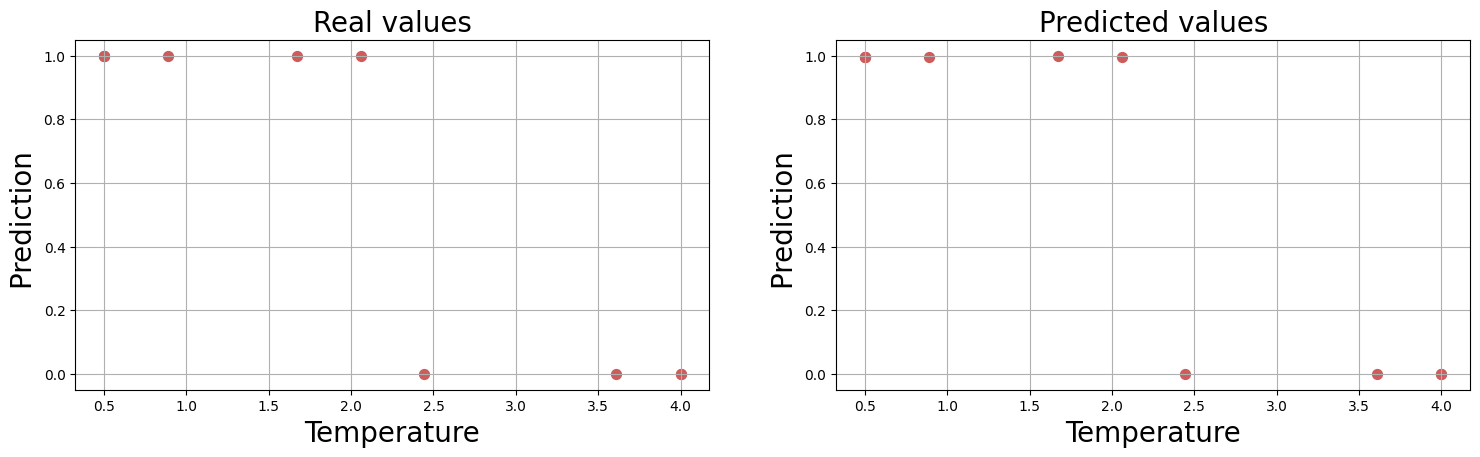

In [ ]:
model.train(False)
test_loader = DataLoader(data_test, batch_size=batch,shuffle=False)
test_accuracy = Accuracy(task="binary", num_classes=2)

for x, y, t in test_loader:
    with torch.no_grad():
        output = model(x)
        true_values = y
        true_temps = t


# Calculate accuracy
accuracy = test_accuracy(output.flatten(), true_values)
print("Test Accuracy:", accuracy)


#plot Prediction vs tempature for truth and pred
f = plt.figure(figsize=(18, 10));
plt.tight_layout()

sp =  f.add_subplot(2, 2, 1 );
plt.title('Real values', fontsize=20)
plt.grid()
plt.scatter(true_temps, y, s=50, marker='o', color='IndianRed')
plt.xlabel("Temperature", fontsize=20);
plt.ylabel("Prediction ", fontsize=20);         plt.axis('tight');

sp =  f.add_subplot(2, 2, 2 );
plt.title('Predicted values', fontsize=20)
plt.grid()
plt.scatter(true_temps, output.flatten(), s=50, marker='o', color='IndianRed')
plt.xlabel("Temperature", fontsize=20);
plt.ylabel("Prediction ", fontsize=20);         plt.axis('tight');

The accuracy obtained from testing the neural nework is 1

# Triangle Ising Model

In this case, the interacting neighbors will be 6 for each element of the lattice. Let´s define some functions

In [ ]:
"This function creates an array that has the same pattern as shown in the project instructions"

def initialize(N: int):
  iarr = np.zeros((N,N))

  for i in range(N):
    if i%2 == 0:
        cont = 2
    else:
        cont = 0

    for j in range(N):
      if cont == 0:
        iarr[i][j] = -1
        cont += 1
      elif cont == 1:
        iarr[i][j] = 1
        cont += 1
      else:
        iarr[i][j] = 1
        cont = 0

  return iarr

print(initialize(7))

[[ 1. -1.  1.  1. -1.  1.  1.]
 [-1.  1.  1. -1.  1.  1. -1.]
 [ 1. -1.  1.  1. -1.  1.  1.]
 [-1.  1.  1. -1.  1.  1. -1.]
 [ 1. -1.  1.  1. -1.  1.  1.]
 [-1.  1.  1. -1.  1.  1. -1.]
 [ 1. -1.  1.  1. -1.  1.  1.]]


In [ ]:
def hamiltonian(iArr, N: int):
    energy = -1/2 * sum(-iArr[i][j] * ( iArr[i][(j+1) % N] + iArr[i][(j-1) % N]+ iArr[(i+1) % N][j] + iArr[(i-1) % N][j] + iArr[(i-1) % N][(j+1)%N] + iArr[(i+1) % N][(j+1)%N]) for i in range(N) for j in range (N))
    return energy

def flip(i,j,iArr,beta):
    M = len(iArr)
    deltaH = 2*iArr[i][j]*(iArr[i][(j+1) % M] + iArr[i][(j-1) % M]+ iArr[(i+1) % M][j] + iArr[(i-1) % M][j] + iArr[(i-1) % M][(j+1)%M] + iArr[(i+1) % M][(j+1)%M])
    if deltaH <= 0 or (deltaH > 0)*(np.random.uniform() < np.exp(-deltaH*beta)):
      iArr[i][j] *= -1
    return iArr


nt = 60
T  = np.round(np.linspace(1, 6, nt),2);
E,M,C,X = np.zeros(nt), np.zeros(nt), np.zeros(nt), np.zeros(nt)
for temp in tqdm (range (nt), desc="Loading..."):
  E[temp],M[temp],C[temp],X[temp]=runTemp(T[temp],10,eqSteps=2000,mcSteps=2000)



Loading...: 100%|██████████| 60/60 [04:57<00:00,  4.96s/it]


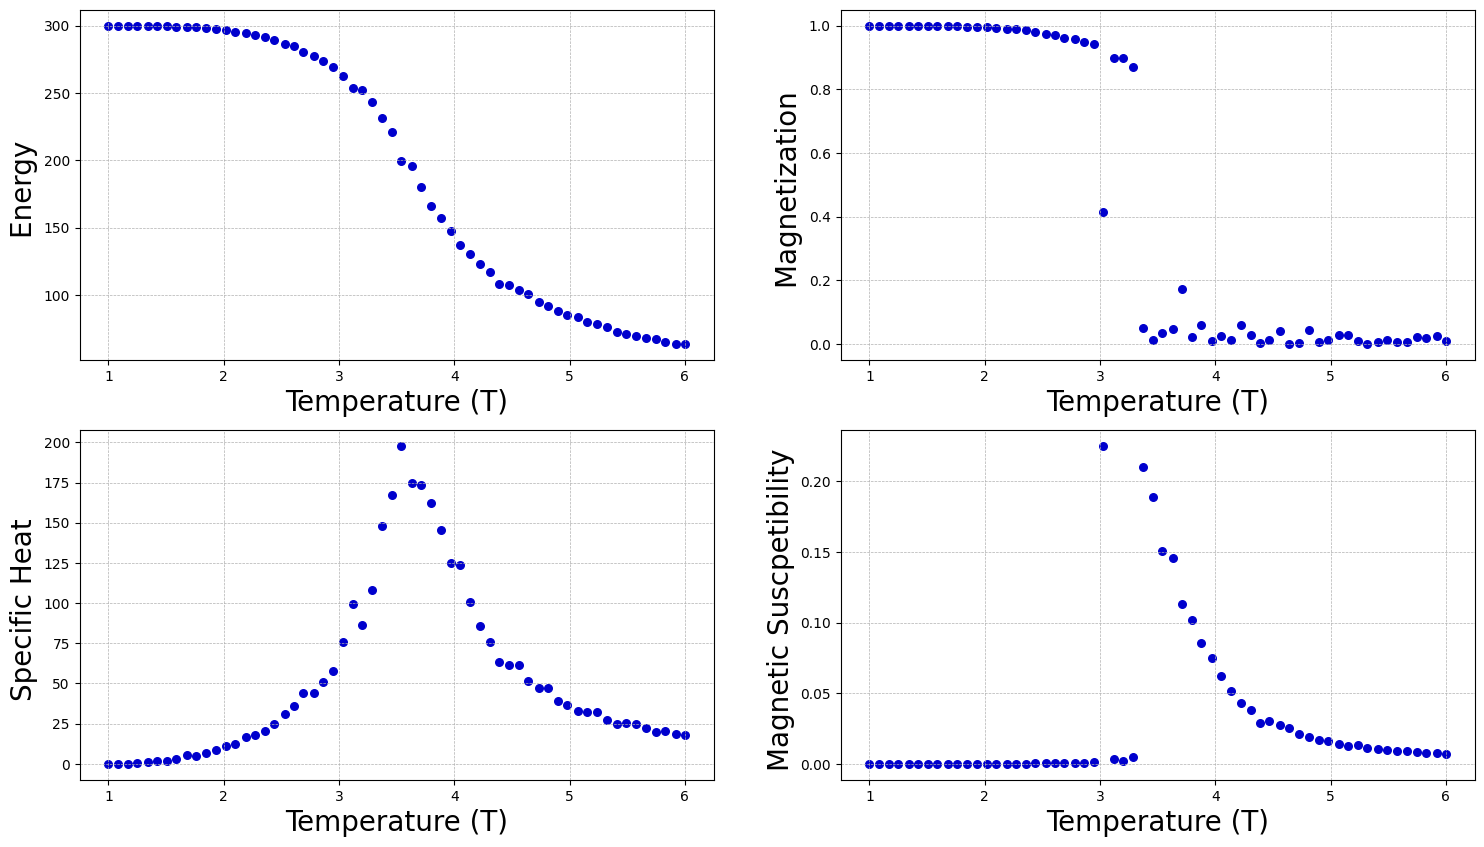

In [ ]:
f = plt.figure(figsize=(18, 10));

sp =  f.add_subplot(2, 2, 1 );
plt.scatter(T, E, s=30, marker='o', color='mediumblue')
plt.xlabel("Temperature (T)", fontsize=20);
plt.ylabel("Energy ", fontsize=20);         plt.axis('tight');
plt.grid(True, which='both', linestyle='--', linewidth=0.5)


sp =  f.add_subplot(2, 2, 2 );
plt.scatter(T, np.abs(M), s=30, marker='o', color='mediumblue')
plt.xlabel("Temperature (T)", fontsize=20);
plt.ylabel("Magnetization ", fontsize=20);         plt.axis('tight');
plt.grid(True, which='both', linestyle='--', linewidth=0.5)


sp =  f.add_subplot(2, 2, 3 );
plt.scatter(T, C, s=30, marker='o', color='mediumblue')
plt.xlabel("Temperature (T)", fontsize=20);
plt.ylabel("Specific Heat ", fontsize=20);         plt.axis('tight');
plt.grid(True, which='both', linestyle='--', linewidth=0.5)


sp =  f.add_subplot(2, 2, 4 );
plt.scatter(T, X, s=30, marker='o', color='mediumblue')
plt.xlabel("Temperature (T)", fontsize=20);
plt.ylabel("Magnetic Suscpetibility ", fontsize=20);         plt.axis('tight');
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

In [ ]:
T_transition = 4/np.log(3)
T_transition

3.6409569065073493

In [ ]:
T = np.round(np.linspace(1, 6, 10),2);
for temp in tqdm (range (10), desc="Loading..."):
    filename='tridata_'+str(T[temp])+'.h5'
    try:
        os.remove(filename)
    except OSError:
        pass
    test = Ising(10,T[temp])
    test.simulate_save('tri')

Loading...:   0%|          | 0/10 [00:00<?, ?it/s]

sim 0
sim 25
sim 50
sim 75


Loading...:  10%|█         | 1/10 [07:40<1:09:01, 460.11s/it]

sim 0
sim 25
sim 50
sim 75


Loading...:  20%|██        | 2/10 [15:21<1:01:27, 460.94s/it]

sim 0
sim 25
sim 50
sim 75


Loading...:  30%|███       | 3/10 [23:03<53:50, 461.47s/it]  

sim 0
sim 25
sim 50
sim 75


Loading...:  40%|████      | 4/10 [30:43<46:03, 460.66s/it]

sim 0
sim 25
sim 50
sim 75


Loading...:  50%|█████     | 5/10 [38:11<38:00, 456.05s/it]

sim 0
sim 25
sim 50
sim 75


Loading...:  60%|██████    | 6/10 [45:18<29:45, 446.32s/it]

sim 0
sim 25
sim 50
sim 75


Loading...:  70%|███████   | 7/10 [52:03<21:38, 432.67s/it]

sim 0
sim 25
sim 50
sim 75


Loading...:  80%|████████  | 8/10 [58:43<14:04, 422.27s/it]

sim 0
sim 25
sim 50
sim 75


Loading...:  90%|█████████ | 9/10 [1:05:53<07:04, 424.86s/it]

sim 0
sim 25
sim 50
sim 75


Loading...: 100%|██████████| 10/10 [1:12:32<00:00, 435.27s/it]


Loading...: 100%|██████████| 10/10 [00:00<00:00, 665.22it/s]


tensor([1.5600, 5.4400, 3.2200, 2.1100, 1.0000, 3.7800, 4.3300, 1.5600, 1.5600,
        3.7800, 3.2200, 4.3300, 3.2200, 3.2200, 3.7800, 2.1100, 2.6700, 2.6700,
        6.0000, 2.6700, 2.6700, 5.4400, 2.1100, 4.3300, 3.2200, 6.0000, 5.4400,
        1.5600, 2.1100, 2.6700, 1.0000, 2.6700, 5.4400, 2.6700, 4.3300, 4.3300,
        2.6700, 3.2200, 1.5600, 4.3300, 1.0000, 2.1100, 3.2200, 1.0000, 1.0000,
        4.8900, 2.6700, 4.3300, 1.5600, 5.4400, 3.7800, 2.6700, 1.0000, 1.0000,
        2.6700, 3.2200, 4.8900, 3.7800, 4.8900, 4.8900, 1.0000, 4.8900, 2.6700,
        4.3300, 6.0000, 1.5600, 4.3300, 6.0000, 2.6700, 5.4400, 4.3300, 3.7800,
        4.8900, 6.0000, 3.7800, 4.8900, 4.3300, 4.8900, 1.5600, 3.2200, 6.0000,
        4.3300, 3.7800, 2.1100, 5.4400, 2.6700, 3.2200, 2.1100, 1.5600, 1.5600,
        3.7800, 1.0000, 1.5600, 6.0000, 1.0000, 2.1100, 5.4400, 1.0000, 1.0000,
        4.8900, 2.1100, 5.4400, 4.8900, 2.1100, 6.0000, 3.2200, 2.1100, 2.6700,
        6.0000, 3.7800, 5.4400, 4.8900, 

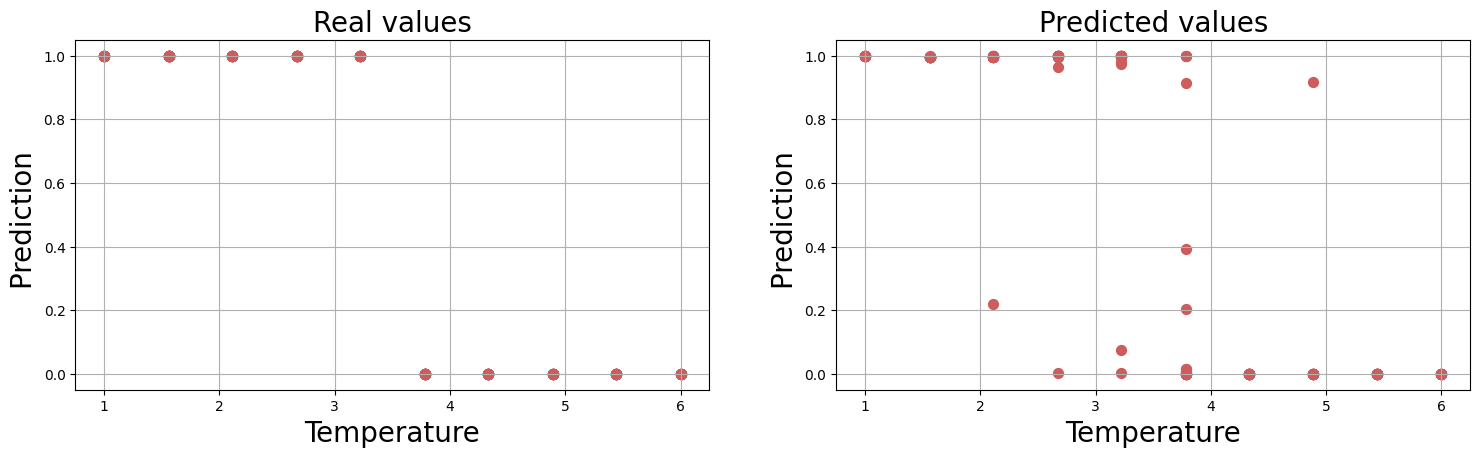

In [ ]:
"This function returns the testing and training data sets"
def load():
    all_data  = None
    all_temps = None
    for temp in tqdm (range (10), desc="Loading..."):
      f = h5py.File('tridata_'+str(T[temp])+'.h5', 'r')
      if temp == 0:
          all_data  = f['data']
          all_temps = np.ones(all_data.shape[0])*T[temp]
      else:
          all_data  = np.append(all_data, f['data'],axis=0)
          all_temps = np.append(all_temps,np.ones(f['data'].shape[0])*T[temp])

    all_data    = np.reshape(all_data,(all_data.shape[0],all_data.shape[1]*all_data.shape[2]))
    all_labels  = np.where(all_temps <= T_transition, 1, 0)
    all_dataset = DataSet(samples=all_data.astype("float32"),labels=all_labels,temps=all_temps)

    train_size = int(0.8*len(all_dataset))
    data_tri_train, data_tri_test = random_split(all_dataset, [train_size, len(all_dataset) - train_size])

    return data_tri_train, data_tri_test

data_tri_train, data_tri_test = load()
batch=1000
test_tri_loader = DataLoader(data_tri_test, batch_size=batch,shuffle=True)


model.train(False)
model.eval()
for x, y, t in test_tri_loader:
    with torch.no_grad():
      output = model(x)
      true_values = y
      temps = t

print(t)
accuracy = test_accuracy(output.flatten(), true_values)
print("Test Accuracy:", accuracy)

f = plt.figure(figsize=(18, 10));
plt.tight_layout()

sp =  f.add_subplot(2, 2, 1 );
plt.title('Real values', fontsize=20)
plt.grid()
plt.scatter(temps, true_values, s=50, marker='o', color='IndianRed')
plt.xlabel("Temperature", fontsize=20);
plt.ylabel("Prediction ", fontsize=20);         plt.axis('tight');

sp =  f.add_subplot(2, 2, 2 );
plt.title('Predicted values', fontsize=20)
plt.grid()
plt.scatter(temps, output.flatten(), s=50, marker='o', color='IndianRed')
plt.xlabel("Temperature", fontsize=20);
plt.ylabel("Prediction ", fontsize=20);         plt.axis('tight');

# Ising 1D

In [ ]:
def initialize(N: int):
    state = 2*np.random.randint(2, size=(N))-1
    return state

'Arreglo de prueba'
N=4
test=initialize(N)
print(test)

[-1 -1  1  1]


In [ ]:
def hamiltonian(Arr, N: int):
    energy = 1/2 * sum(-Arr[i] * ( Arr[(i+1) % N] + Arr[(i-1) % N]) for i in range(N))
    return energy

def flip(i: int, Arr, Beta: float):
  M = len(Arr)
  deltaH = 2*Arr[i]*(Arr[(i+1)%M] + Arr[(i-1)%M])
  if deltaH <= 0 or (deltaH > 0)*(np.random.uniform() < np.exp(-deltaH*Beta)):
    Arr[i] *= -1
  return Arr

#test
print("Before Flip:\n",test)
flip(2,test,1)
print("After Flip:\n",test)


Before Flip:
 [-1 -1  1  1]
After Flip:
 [-1 -1 -1  1]


In [ ]:
def mag(Arr, N):
  M = np.sum(Arr)
  return M/N

def update_rand(Arr,N,beta):
  index = [i for i in range(N)]
  samples = random.sample(index, N)
  for n in samples:
    flip(n, Arr, beta)
  return Arr

N = 100
nt = 80
T  = np.linspace(0.5,4,nt)
E,M,C,X = np.zeros(nt), np.zeros(nt),np.zeros(nt), np.zeros(nt)
for temp in tqdm (range (nt), desc="Loading..."):
    E[temp],M[temp], C[temp], X[temp] = runTemp(T[temp],N,eqSteps=2000,mcSteps=2000)

Loading...: 100%|██████████| 80/80 [03:08<00:00,  2.36s/it]


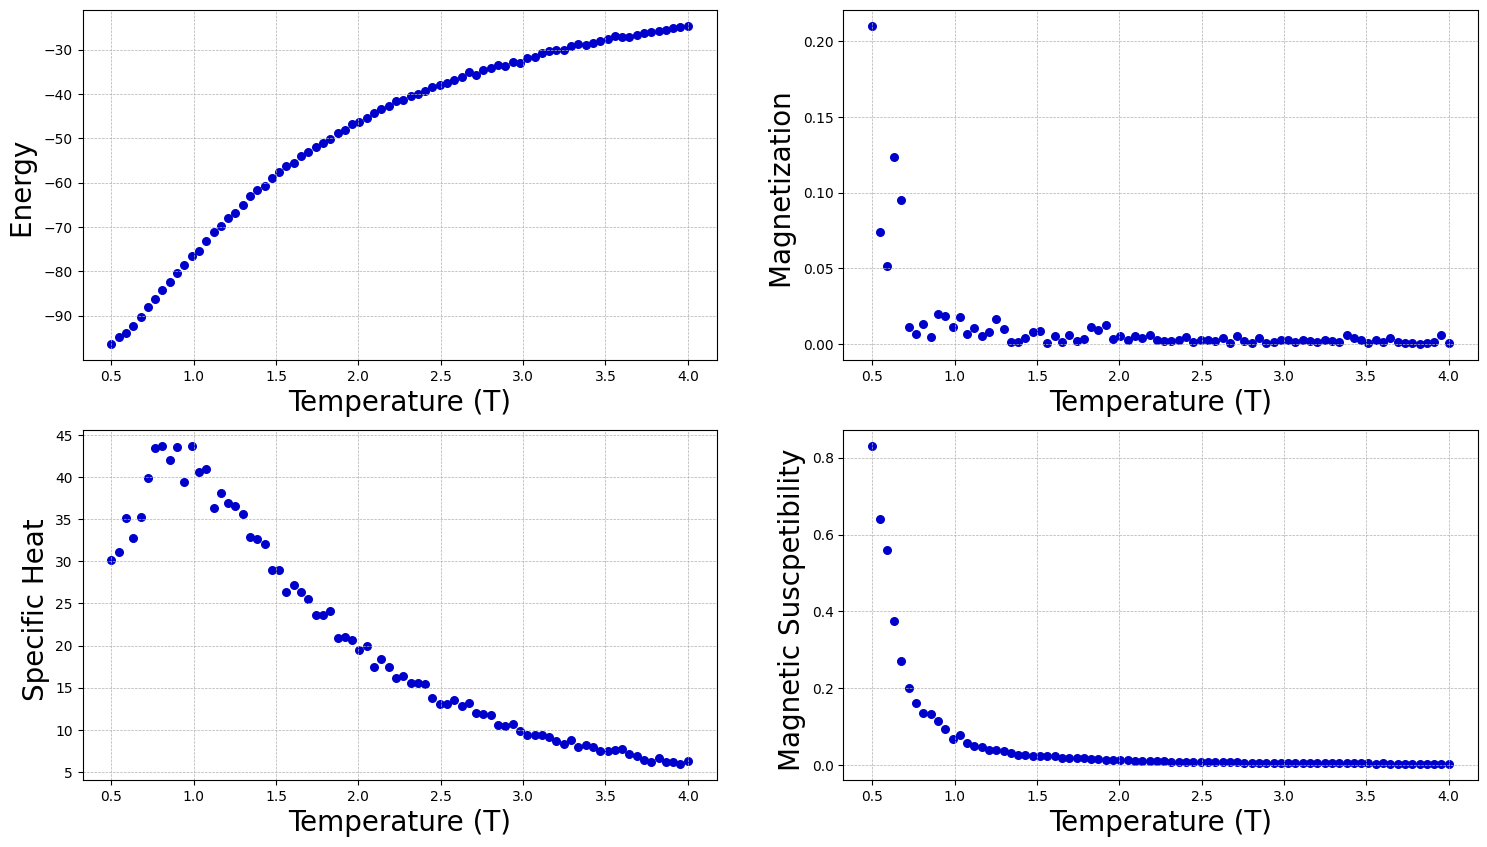

In [ ]:
f = plt.figure(figsize=(18, 10));

sp =  f.add_subplot(2, 2, 1 );
plt.scatter(T, E, s=30, marker='o', color='mediumblue')
plt.xlabel("Temperature (T)", fontsize=20);
plt.ylabel("Energy ", fontsize=20);         plt.axis('tight');
plt.grid(True, which='both', linestyle='--', linewidth=0.5)


sp =  f.add_subplot(2, 2, 2 );
plt.scatter(T, np.abs(M), s=30, marker='o', color='mediumblue')
plt.xlabel("Temperature (T)", fontsize=20);
plt.ylabel("Magnetization ", fontsize=20);         plt.axis('tight');
plt.grid(True, which='both', linestyle='--', linewidth=0.5)


sp =  f.add_subplot(2, 2, 3 );
plt.scatter(T, C, s=30, marker='o', color='mediumblue')
plt.xlabel("Temperature (T)", fontsize=20);
plt.ylabel("Specific Heat ", fontsize=20);         plt.axis('tight');
plt.grid(True, which='both', linestyle='--', linewidth=0.5)


sp =  f.add_subplot(2, 2, 4 );
plt.scatter(T, X, s=30, marker='o', color='mediumblue')
plt.xlabel("Temperature (T)", fontsize=20);
plt.ylabel("Magnetic Suscpetibility ", fontsize=20);         plt.axis('tight');
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

#Ising 3D

In [ ]:
def initialize(N: int):
    state = 2*np.random.randint(2, size=(N,N,N))-1
    return state


In [ ]:
"This function returns the energy of the grid"
def hamiltonian(iArr, N: int):
  for i in range(N):
    for j in range(N):
      for k in range(N):
        energy = 1/2 * (-iArr[i][j][k] * ( iArr[i][(j+1) % N][k] + iArr[i][(j-1) % N][k]+ iArr[(i+1) % N][j][k] + iArr[(i-1) % N][j][k] + iArr[i][j][(k+1) % N] + iArr[i][j][(k-1) % N]) )
    # the 1/2 is to account for the double counting
    return energy



In [ ]:
def flip(i: int, j: int, k: int, iArr, Beta: float):
  M = len(iArr)
  deltaH = 2*iArr[i][j][k]*(iArr[i][(j+1)%M][k] + iArr[i][(j-1)%M][k] + iArr[(i+1)%M][j][k] + iArr[(i-1)%M][j][k]+ iArr[i][j][(k+1) % M] + iArr[i][j][(k-1) % M])
  if deltaH <= 0 or (deltaH > 0)*(np.random.uniform() < np.exp(-deltaH*Beta)):
    iArr[i][j][k] *= -1
  return iArr

In [ ]:
def mag(Arr, N):
  M = np.sum(Arr)
  return M/N**3


"update_rand tries to flip the spin in every position of the array"
def update_rand(Arr,N,beta):
  index = [(row, col, k) for row in range(N) for col in range(N) for k in range(N)]
  samples = random.sample(index, N*N*N)
  for n in range(len(samples)):
    row, col, k = samples[n]
    flip(row, col, k, Arr, beta)
  return Arr

In [ ]:
def runTemp(T,N,eqSteps=500,mcSteps=500):
    Arr = initialize(N)                            # initialize
    Ene= []
    Mag = []
    Mag2 = []
    Ene2 = []
    beta=1/(k*T)

    for i in range(eqSteps):                       # equilibrate
        update_rand(Arr, N, beta)

    for i in range(mcSteps):
        update_rand(Arr, N, beta)

        Ene.append(hamiltonian(Arr, N))
        Ene2.append(hamiltonian(Arr, N)**2)
        Mag.append(mag(Arr, N))
        Mag2.append(mag(Arr, N)**2)



    E = sum(Ene)/len(Ene)
    M = sum(Mag)/len(Mag)
    C = (sum(Ene2)/len(Ene2)-E**2)/T**2
    X = (sum(Mag2)/len(Mag2)-M**2)/T
    return E,M,C,X

In [ ]:
N = 5
nt = 50
T  = np.linspace(0.5,7,nt)
E,M,C,X = np.zeros(nt), np.zeros(nt),np.zeros(nt), np.zeros(nt)
for temp in tqdm (range (nt), desc="Loading..."):
    E[temp],M[temp],C[temp],X[temp] = runTemp(T[temp],N,eqSteps=2000,mcSteps=2000)

Loading...: 100%|██████████| 50/50 [04:56<00:00,  5.93s/it]


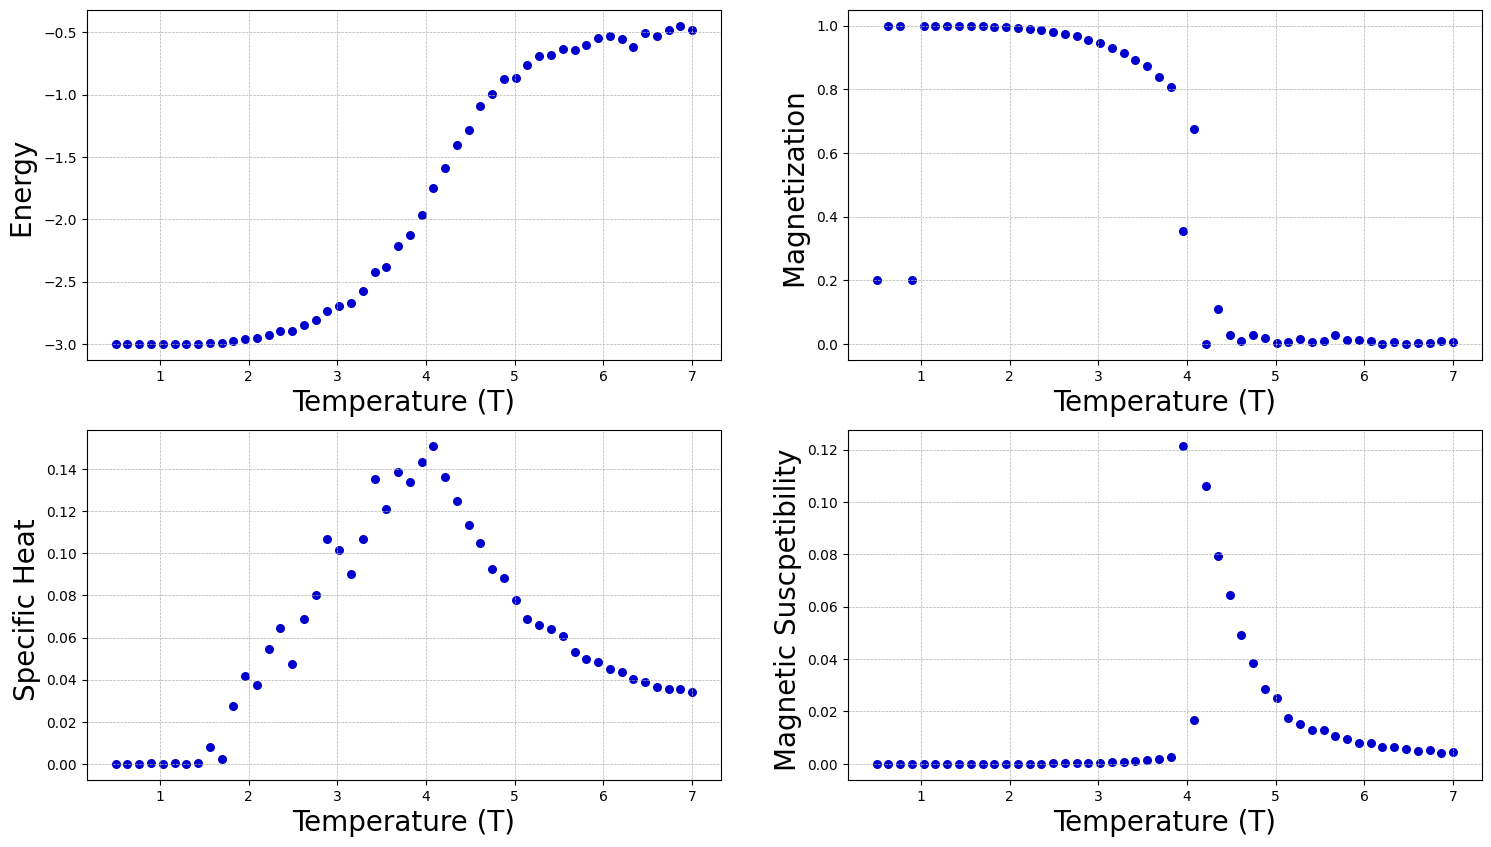

In [ ]:
f = plt.figure(figsize=(18, 10));

sp =  f.add_subplot(2, 2, 1 );
plt.scatter(T, E, s=30, marker='o', color='mediumblue')
plt.xlabel("Temperature (T)", fontsize=20);
plt.ylabel("Energy ", fontsize=20);         plt.axis('tight');
plt.grid(True, which='both', linestyle='--', linewidth=0.5)


sp =  f.add_subplot(2, 2, 2 );
plt.scatter(T, np.abs(M), s=30, marker='o', color='mediumblue')
plt.xlabel("Temperature (T)", fontsize=20);
plt.ylabel("Magnetization ", fontsize=20);         plt.axis('tight');
plt.grid(True, which='both', linestyle='--', linewidth=0.5)


sp =  f.add_subplot(2, 2, 3 );
plt.scatter(T, C, s=30, marker='o', color='mediumblue')
plt.xlabel("Temperature (T)", fontsize=20);
plt.ylabel("Specific Heat ", fontsize=20);         plt.axis('tight');
plt.grid(True, which='both', linestyle='--', linewidth=0.5)


sp =  f.add_subplot(2, 2, 4 );
plt.scatter(T, X, s=30, marker='o', color='mediumblue')
plt.xlabel("Temperature (T)", fontsize=20);
plt.ylabel("Magnetic Suscpetibility ", fontsize=20);         plt.axis('tight');
plt.grid(True, which='both', linestyle='--', linewidth=0.5)